# Identify Customers Segments for Marketing Campaigns<a class="tocSkip">
###  Applying unsupervised learning techniques in [`scikit-learn`](https://scikit-learn.org/stable/)<a class="tocSkip">
    
---
## Motivation
    
### Business question

Identify segments of the population, based on historical customer data, that form the core customer base for a mail-order sales company in Germany. These segments can then be used to deploy direct marketing campaigns towards specific audiences in the general population which will have the highest expected rate of return.


### Data Science motivation

Apply unsupervised learning tools included in [`scikit-learn`](https://scikit-learn.org/stable/) for dimensionality reduction and clustering:
- [Principal component analysis (PCA)](https://scikit-learn.org/stable/modules/decomposition.html#decompositions)
- [K-means](https://scikit-learn.org/stable/modules/clustering.html#k-means)

---
## Import Python modules and data

In [77]:
# Import libraries necessary for this project
from collections import Counter
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# scikit-learn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Pretty display for Jupyter notebooks
%matplotlib inline

In [78]:
# Set plots aesthetic parameters in one step.
sns.set(context='notebook', color_codes=True, 
        font='sans-serif', font_scale=1.15)

### Load the datasets

There are four data files associated with this project:

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891,211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191,652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns.

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. This information will be used to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those population clusters.

In [79]:
# Load the general demographics data
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';', quotechar='"')

# Load the feature summary file
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';', quotechar='"')

In [80]:
# Check the shape of the data
print('Shape of Udacity_AZDIAS_Subset.csv : {:,} x {} \n'\
      .format(azdias.shape[0], azdias.shape[1]))
print('Shape of AZDIAS_Feature_Summary.csv : {:,} x {}'\
      .format(feat_info.shape[0], feat_info.shape[1]))

Shape of Udacity_AZDIAS_Subset.csv : 891,221 x 85 

Shape of AZDIAS_Feature_Summary.csv : 85 x 4


In [81]:
# Print the fir few rows of azdias
print('First few rows of Udacity_AZDIAS_Subset.csv:')
azdias.head()

First few rows of Udacity_AZDIAS_Subset.csv:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [82]:
# Print the first few rows of feat_info
print('First few rows of AZDIAS_Feature_Summary.csv:')
feat_info.head()

First few rows of AZDIAS_Feature_Summary.csv:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


---
## Preprocess data for `scikit-learn` algorithms

### Re-encode codes for missing-or-unkown values into NumPy NaNs

The feature summary file contains a summary of properties for each demographics data column. This file helps to make cleaning decisions during this stage of the project.  

The fourth column of the feature attributes summary lists the codes from the data dictionary that indicate missing or unknown values. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. The function `str_to_list()` below re-encodes these strings into usable lists. 

In [83]:
# Helper function 
def str_to_list(str_of_list):
    """Take a string object containing the list of codes for missing or 
    unkown values and return a list of strings.
    
    Args: 
        str_of_list (str): List of codes.
    
    Returns: 
        List of strings
        
    """
    # Remove brackets
    str_of_list = str_of_list[1:-1]
    # Split string using separator = ','
    return str_of_list.split(sep=',')

In [84]:
# Test the helper function str_to_list()
# Take one attribute to test 
test_attribute = 'CAMEO_INTL_2015'
bool_idx = feat_info['attribute'] == test_attribute
codes = feat_info['missing_or_unknown'][bool_idx].iloc[0]

# Print test result
print('Missing codes for test attribute', test_attribute, ':')
print(str_to_list(codes))

Missing codes for test attribute CAMEO_INTL_2015 :
['-1', 'XX']


In [85]:
# Explore the unique elements associated with the same example attribute
# to understand the contrast between naturally and encoded missing data: 
print('Posible values for test feature "{}":\n {}'\
      .format(test_attribute, azdias[test_attribute].unique()))

Posible values for test feature "CAMEO_INTL_2015":
 [nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32' 'XX']


For the test attribute `CAMEO_INTL_2015`, naturally missing values were read in as NaNs and missing-or-unkown values were pre-encoded as `'XX'`. Typical integer values were read in as string objects.

In [86]:
# Add a column to feat_info: lists of codes for missing values
feat_info['missing_codes'] = [str_to_list(string) \
                              for string \
                              in feat_info['missing_or_unknown']]
feat_info.head()

,attribute,information_level,type,missing_or_unknown,missing_codes
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [87]:
# Copy the raw azdias dataframe before replacing encoded missing values
# azdias will be the working dataframe
azdias_raw = azdias.copy(deep=True)

Below I make a dataframe with one column of all features and a second column counting the encoded missing values. I also replace these encoded values with NumPy NaN values.

In [88]:
# Create dataframe to count encoded missing values
encoded_missing = pd.DataFrame(columns=['feature', 'code', 'count_missing'])

for feature in azdias:
    # Retrieve list of codes for missing values from feat_info
    bool_idx = feat_info['attribute'] == feature
    nan_codes = feat_info.loc[bool_idx, 'missing_codes'].iloc[0] 
    # Iterate through list of codes
    for code in nan_codes:
        if code == '': 
            continue
        # Transform code from string to integer 
        if code.isnumeric() or code.lstrip('-').isnumeric():
            code = int(code)
        # Replace coded values in azdias dataframe with numpy NaN
        bool_idx = azdias[feature] == code
        azdias.loc[bool_idx, feature] = np.nan
        # Count missing values and add to dataframe
        new_row = {'feature':feature, 
                   'code':code, 
                   'count_missing':sum(bool_idx)}
        encoded_missing = encoded_missing.append(new_row, ignore_index=True)

In [89]:
# Get the percentage of natually missing values in the dataset
nat_missing = azdias_raw.isnull().sum().sum()
print('Percentage of naturally missing values: {:1.2f}%'\
      .format(nat_missing/azdias_raw.size*100))

Percentage of naturally missing values: 6.46%


In [90]:
# Get the percentage of encoded missing values in the dataset
enc_missing = encoded_missing['count_missing'].sum()
print('Percentage of encoded missing values: {:1.2f}%'\
      .format(enc_missing/azdias.size*100))

Percentage of encoded missing values: 4.59%


In [91]:
# Get the percentage of total missing values in the dataset
total_missing = azdias.isnull().sum().sum()
print('Percentage of total missing values: {:1.2f}%'\
      .format(total_missing/azdias.size*100))

Percentage of total missing values: 11.05%


### Assess proportion of missing data per column

There may be a few columns that are outliers in terms of the proportion of values that are missing. In order to find these columns, I will rely on histograms: visualizing the distribution of missing value counts.

In [92]:
# Add new columns to 'feat_info' to include missing data metrics
for column in azdias:
    count = azdias[column].isnull().sum()
    pct_missing = count / azdias.shape[0] * 100
    bool_idx = feat_info['attribute'] == column
    feat_info.loc[bool_idx, 'count_missing'] = count
    feat_info.loc[bool_idx, 'pct_missing'] = pct_missing

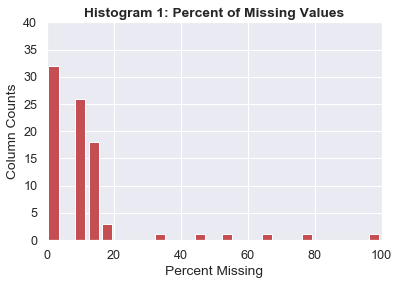

In [93]:
# Build a histogram with the series of percent missing values
plt.hist(feat_info['pct_missing'], bins=25, facecolor='r', rwidth=0.75)
plt.xlabel('Percent Missing')
plt.ylabel('Column Counts')
plt.title('Histogram 1: Percent of Missing Values', fontweight='bold')
plt.axis([0, 100, 0, 40])
plt.grid(True)
plt.show()

#### Drop columns due to high proportion of missing data

In [94]:
# Identify outlier columns as the ones with proportion of missing vales 
# greater than 20%:
bound = 20
outliers = feat_info.loc[feat_info['pct_missing'] > bound, 'attribute']
print('Features with more than {}% missing values:\n'.format(bound), outliers)

Features with more than 20% missing values:
 0         AGER_TYP
11     GEBURTSJAHR
40        TITEL_KZ
43        ALTER_HH
47    KK_KUNDENTYP
64    KBA05_BAUMAX
Name: attribute, dtype: object


In [95]:
# Checks that `azdias` contains the outliers columns 
_drops = [col for col in outliers if col in azdias.columns]
# Drop columns
azdias.drop(labels=_drops, axis=1, inplace=True)

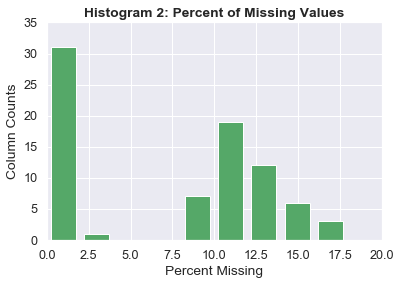

In [96]:
# Build a second histogram of the series of percent missing values 
# — now with the remaining 79 features.
plt.hist(feat_info['pct_missing'], bins=50, facecolor='g', rwidth=0.75)
plt.xlabel('Percent Missing')
plt.ylabel('Column Counts')
plt.title('Histogram 2: Percent of Missing Values', fontweight='bold')
plt.axis([0, 20, 0, 35])
plt.grid(True)
plt.show()

#### Missing data patterns in remaining columns

Below, I investigate some patterns in the amount of missing data in the remaining 79 features.

In [97]:
# Identify 32 features with less than 5% missing values
missing_5pc = feat_info.loc[feat_info['pct_missing'] < 5, 'attribute']
print(len(missing_5pc), 'features with less than 5% missing data:\n')
print(missing_5pc)

32 features with less than 5% missing data:

1      ALTERSKATEGORIE_GROB
2                 ANREDE_KZ
3             CJT_GESAMTTYP
4         FINANZ_MINIMALIST
5             FINANZ_SPARER
6          FINANZ_VORSORGER
7            FINANZ_ANLEGER
8     FINANZ_UNAUFFAELLIGER
9          FINANZ_HAUSBAUER
10                FINANZTYP
12          GFK_URLAUBERTYP
13         GREEN_AVANTGARDE
19           LP_STATUS_FEIN
20           LP_STATUS_GROB
23           RETOURTYP_BK_S
24                SEMIO_SOZ
25                SEMIO_FAM
26                SEMIO_REL
27                SEMIO_MAT
28               SEMIO_VERT
29               SEMIO_LUST
30                SEMIO_ERL
31               SEMIO_KULT
32                SEMIO_RAT
33               SEMIO_KRIT
34                SEMIO_DOM
35               SEMIO_KAEM
36            SEMIO_PFLICHT
37              SEMIO_TRADV
42                 ZABEOTYP
46       HH_EINKOMMEN_SCORE
72        ONLINE_AFFINITAET
Name: attribute, dtype: object


In [98]:
# Identify 47 features with 5%-20% missing values
bool_idx = (feat_info['pct_missing'] > 5) & (feat_info['pct_missing'] < 20)
missing_5_20 = feat_info.loc[bool_idx, 'attribute']
print(len(missing_5_20), 'features with 5%-20% missing data:\n') 
print(missing_5_20)

47 features with 5%-20% missing data:

14               HEALTH_TYP
15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
17          LP_FAMILIE_FEIN
18          LP_FAMILIE_GROB
21         NATIONALITAET_KZ
22    PRAEGENDE_JUGENDJAHRE
38              SHOPPER_TYP
39                  SOHO_KZ
41                 VERS_TYP
44             ANZ_PERSONEN
45                ANZ_TITEL
48           W_KEIT_KIND_HH
49           WOHNDAUER_2008
50      ANZ_HAUSHALTE_AKTIV
51             ANZ_HH_TITEL
52              GEBAEUDETYP
53              KONSUMNAEHE
54         MIN_GEBAEUDEJAHR
55              OST_WEST_KZ
56                 WOHNLAGE
57          CAMEO_DEUG_2015
58           CAMEO_DEU_2015
59          CAMEO_INTL_2015
60              KBA05_ANTG1
61              KBA05_ANTG2
62              KBA05_ANTG3
63              KBA05_ANTG4
65                KBA05_GBZ
66                 BALLRAUM
67                 EWDICHTE
68               INNENSTADT
69       GEBAEUDETYP_RASTER
70                      KKK
71       

In [99]:
# Print the count of attributes grouped by the information_level
print('Features with less than 5% missing values.\
        \nCount per "information_level":\n')
print(feat_info.loc[missing_5pc.index, 'information_level'].value_counts())

Features with less than 5% missing values.        
Count per "information_level":

person        30
region_rr1     1
household      1
Name: information_level, dtype: int64


In [100]:
# Print the count of attributes grouped by the information_level
print('Features with 5%-20% missing values.\
        \nCount per "information_level":\n')
print(feat_info.loc[missing_5_20.index, 'information_level'].value_counts())

Features with 5%-20% missing values.        
Count per "information_level":

person            10
macrocell_plz8     8
building           7
microcell_rr3      5
region_rr1         4
household          4
community          3
postcode           3
microcell_rr4      3
Name: information_level, dtype: int64


In [101]:
# Print the count of attributes grouped by the information_level
print('Outliers, more than 20% missing values.\
        \nCount per "information_level":\n')
print(feat_info.loc[outliers.index, 'information_level'].value_counts())

Outliers, more than 20% missing values.        
Count per "information_level":

person           3
household        2
microcell_rr3    1
Name: information_level, dtype: int64


#### Discussion of missing data per column

First, I built a new DataFrame of the features in `azdias` which includes their corresponding count of missing values as well as the proportion of missing values. 

I used this DataFrame to create Histogram 1 (red bars) with the series of percent missing values, which shows that there are 6 features/columns that are missing more than 20% of their values. I drop these 6 columns from `azdias`. 

Using the remaining 79 features, I created Histogram 2 (green bars) with the series of percent missing values. This histogram shows that 32 features have less than 5% missing values, with another group of 47 features having 5% - 20% missing values. 

In order to investigate patterns in the amount of missing data in these remaining 79 features, I separated the features into these two groups:

1. attributes with less than 5% missing values.
2. attributes with 5% - 20% missing values.

Finally I used the `feat_info` DataFrame to investigate whether the most relevant characteristic of the attributes, "information_level", is associated with the amount of missing data.

I found that for the 32 attributes with less than 5% missing values, 30 are observed at the person level. In contrast, the 47 attributes with 5% - 20% missing values are more evenly distributed with respect to information level: 10 are person level, 4 are household level, and the remaining 33 are higher levels of aggregation (e.g., building, region, post code).

I went back to do a similar analysis of the outliers — columns with more than 20% missing values — and found that 3 are observed at the person level, 2 at the household level, and 1 at the microcell level.

### Assess proportion of missing data per row

The analysis in this section is analogous to the previous section, but here I assess the proportions and counts of missing values per row. 

First I visualize the patterns of missing data per row in the entire dataset. Then I divide the data into subsets based on thresholds for missing values per row.

In [102]:
# Count missing values per row
count_missing = azdias.isnull().sum(axis=1)
pct_missing = np.float16(count_missing / azdias.shape[1] * 100)

In [103]:
# Use a counter to get the number of rows that show 
# a given number of missing features:
counter = Counter(count_missing)
# Print the counts for the relevant subset of missing features
for i in range(count_missing.min(), count_missing.max()+1):
    if i in counter:
        print('Rows with {} missing features: {:,}'.format(i, counter[i]))

Rows with 0 missing features: 623,209
Rows with 1 missing features: 15,738
Rows with 2 missing features: 27,926
Rows with 3 missing features: 17,629
Rows with 4 missing features: 12,607
Rows with 5 missing features: 22,515
Rows with 6 missing features: 13,771
Rows with 7 missing features: 13,714
Rows with 8 missing features: 24,592
Rows with 9 missing features: 3,042
Rows with 10 missing features: 5,410
Rows with 11 missing features: 1,127
Rows with 12 missing features: 766
Rows with 13 missing features: 3,255
Rows with 14 missing features: 2,243
Rows with 15 missing features: 4,743
Rows with 16 missing features: 2,505
Rows with 17 missing features: 677
Rows with 18 missing features: 428
Rows with 19 missing features: 1,180
Rows with 20 missing features: 349
Rows with 21 missing features: 150
Rows with 22 missing features: 129
Rows with 23 missing features: 132
Rows with 24 missing features: 69
Rows with 25 missing features: 55
Rows with 26 missing features: 59
Rows with 27 missing fea

Clearly the great majority of rows (623,209) have no missing values. 

Below I use a histogram to visualize the distribution of missing values per row in the dataset. 

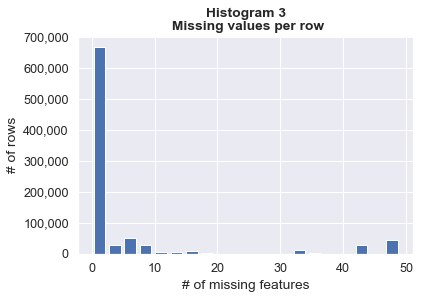

In [104]:
# Build a histogram with the series of missing features per row
ax1 = plt.subplot()
plt.hist(count_missing, bins=20, facecolor='b', rwidth=0.75)
plt.xlabel('# of missing features')
plt.ylabel('# of rows')
plt.title('Histogram 3\n Missing values per row', fontweight='bold')
plt.grid(True)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
plt.show()

Since most rows have no missing values, the histogram above is dominated by the bar including the count of zero. In order to have a more informative view, I build the same histogram but for rows with a positive count (one or more) of missing values. 

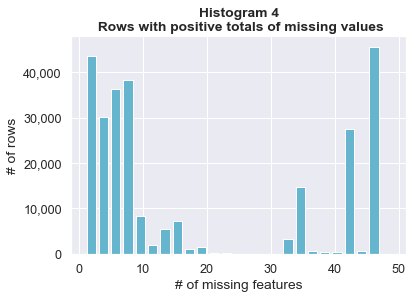

In [105]:
# Build second histogram with the series of missing features per row
# with modified axis in order to zoom into rows with missing values
ax2 = plt.subplot()
plt.hist(count_missing[count_missing > 0], bins=25, facecolor='c', rwidth=0.75)
plt.xlabel('# of missing features')
plt.ylabel('# of rows')
plt.title('Histogram 4\n Rows with positive totals of missing values', 
          fontweight='bold')
plt.grid(True)
ax2.set_yticklabels(['{:,}'.format(int(x)) for x in ax2.get_yticks().tolist()])
plt.show()

Based on the histogram above, I decided to separate rows into three groups depending upon their count of missing values:

1. Eight (8) of fewer missing values

2. Between nine (9) and thirty-two (32) missing values

3. Thirty-three (33) or more missing values

Below I calculate the counts of rows per each one of these groups.

In [106]:
# Print dimensions of subsets
print('Subset 1 : # of rows with missing features <= 8:\n  {:,}'\
      .format(sum(count_missing <= 8)))
print('Subset 2 : # of rows with 9 <= missing features <= 32:\n  {:,}'\
      .format(sum((count_missing >= 9) & (count_missing <= 32))))
print('Subset 3 : # of rows with missing features > 32:\n  {:,}'\
      .format(sum(count_missing > 32)))

Subset 1 : # of rows with missing features <= 8:
  771,701
Subset 2 : # of rows with 9 <= missing features <= 32:
  26,575
Subset 3 : # of rows with missing features > 32:
  92,945


#### Compare the distributions of values between the subsets

In order to know what to do with outlier rows (in terms of missing values), I split the dataset and separately calculate the distributions of data values on columns that are not missing data (or are missing very little data) for the subsets of data defined in the previous section. 

This comparison of distributions has important implications on how to approach the rows with many missing values. If the distributions look similar between the subsets of data, then one could argue that the rows with many missing values are a random sample of the population; and simply dropping these rows from the analysis would be reasonable. 

On the other hand, if the distributions look very different between the subsets of data, then one should note that the rows with many missing values are systematically different from the rest of the data. In this case, one can either drop the rows acknowledging that this may introduce important biases in the analysis, or keep the rows and impute the missing values.  

In [107]:
# Helper function
def cat_distribution(df_1, df_2, df_3, column_name):
    """Plot the distributions of values, for a single feature in the 
    dataset, for the different subsets defined based on missing values 
    per row.
    
    Args: 
        df_1 (DataFrame)
        df_2 (DataFrame)
        df_3 (DataFrame)
        column_name (str): Column/feature name.
    
    Returns: 
        None. Plot the distributions side by side.
        
    """   
    plt.figure(figsize=(8,4))
    for df, sub_plot in [(df_1, 1), (df_2, 2), (df_3, 3)]:  
        ax = plt.subplot(1, 3, sub_plot)
        sns.countplot(x=column_name, data=df)
        
        y_ticks = []
        for n in ax1.get_yticks().tolist():
            if n < 1000:
                y_ticks.append(str(int(n)))
            else:
                y_ticks.append(str(int(n))[:-3] + 'k')
        ax.set_yticklabels(y_ticks)
        
        ax.set_xticklabels([str(int(x)) for x in ax1.get_xticks().tolist()])   
        ax.set_xlabel('subset ' + str(sub_plot))
        if sub_plot == 1:
            ax.set_ylabel('# of rows')
        else:
            ax.set_ylabel(None)
            
    plt.suptitle(column_name)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [108]:
# Identify the columns with no missing data
count_per_col = azdias.isnull().sum(axis=0)
clean_cols = count_per_col[count_per_col == 0].index
print('Columns with no missing data: ', len(clean_cols))
print('\n',clean_cols)

Columns with no missing data:  24

 Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')


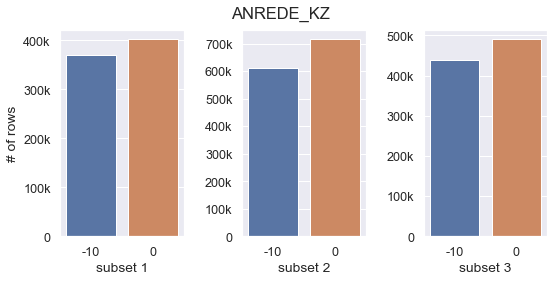

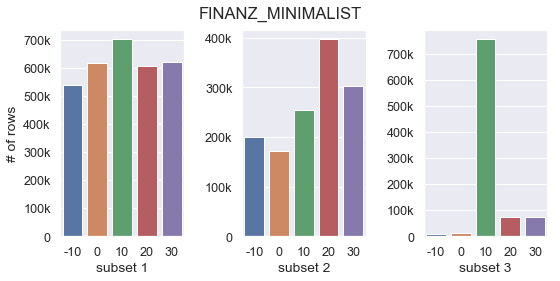

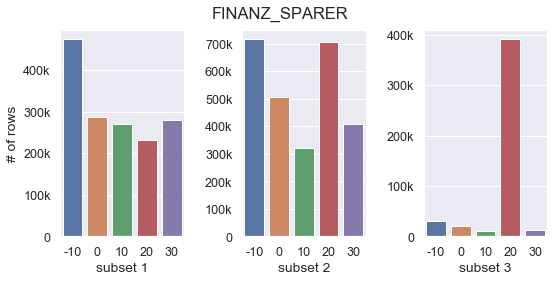

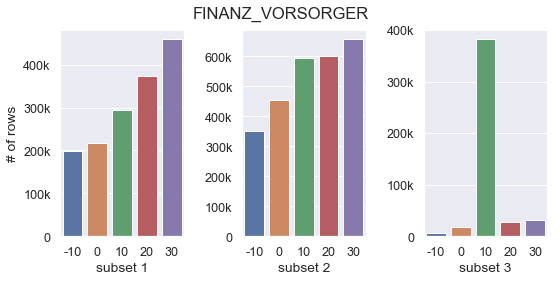

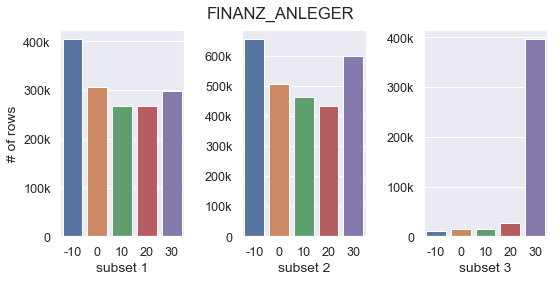

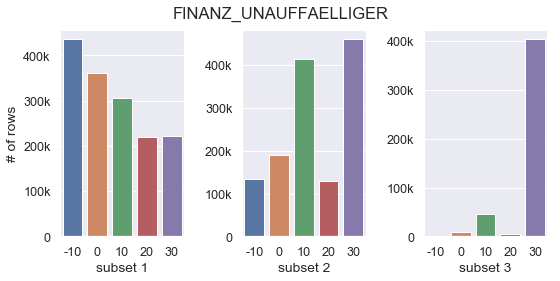

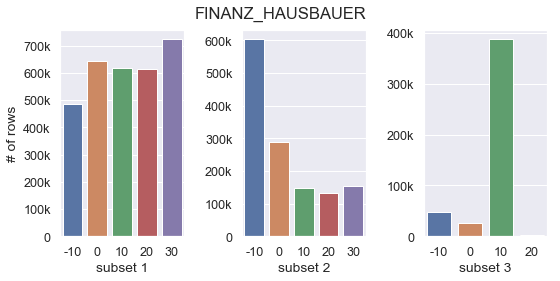

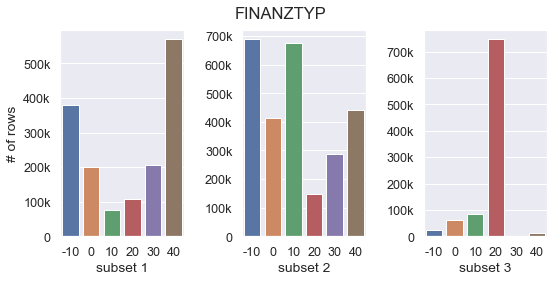

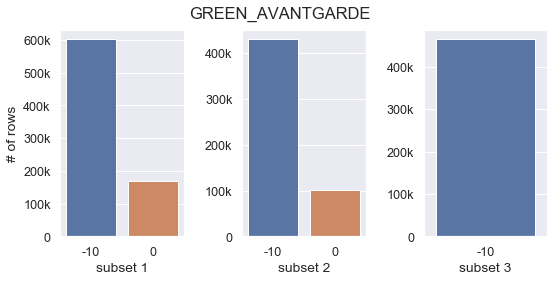

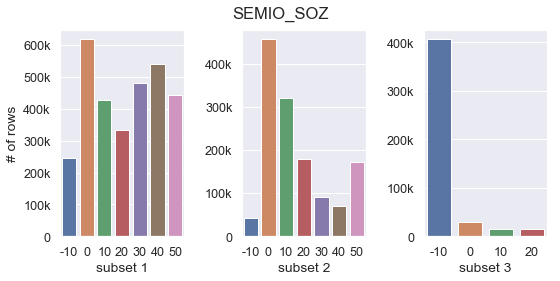

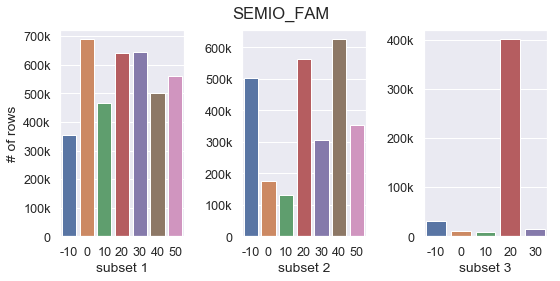

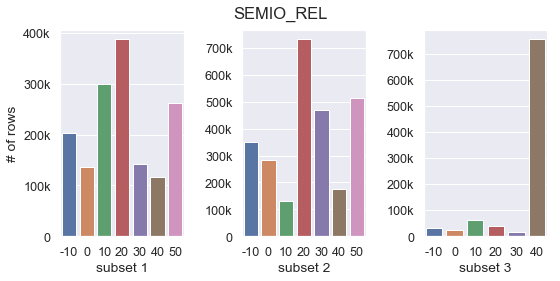

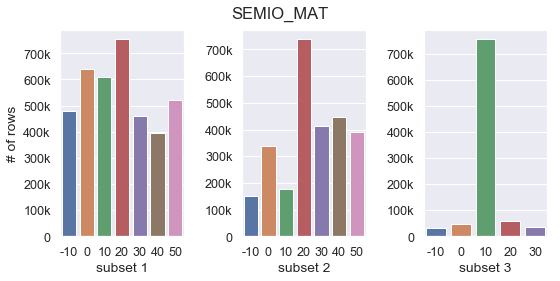

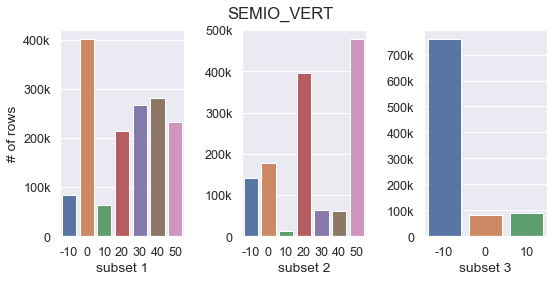

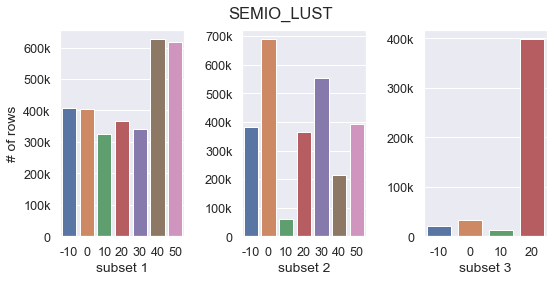

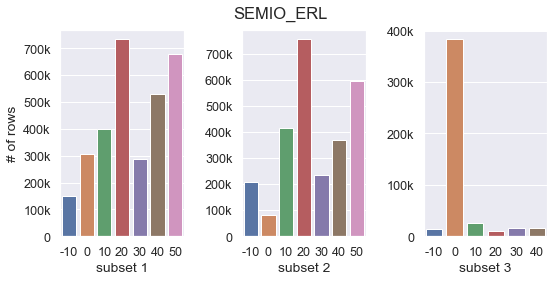

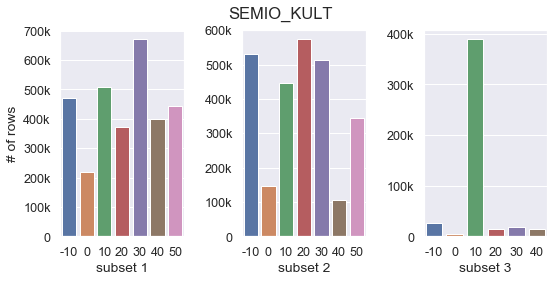

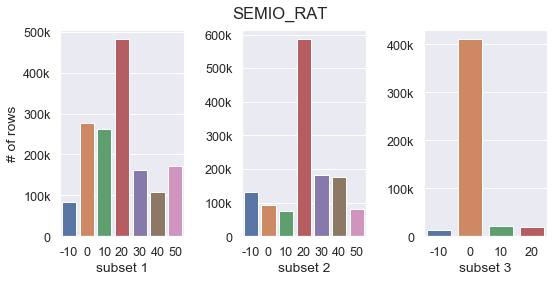

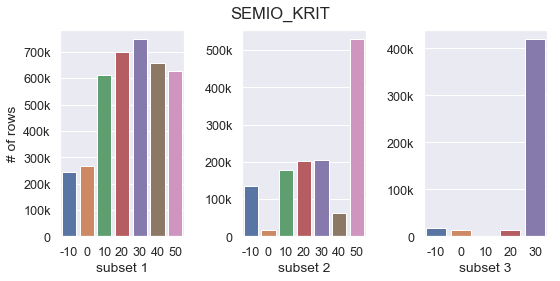

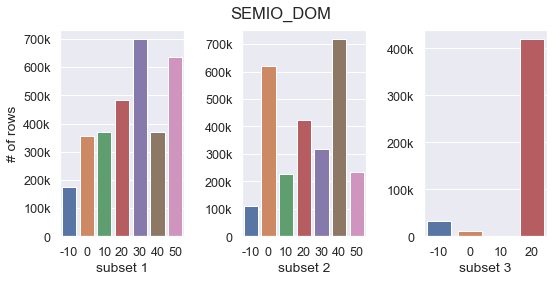

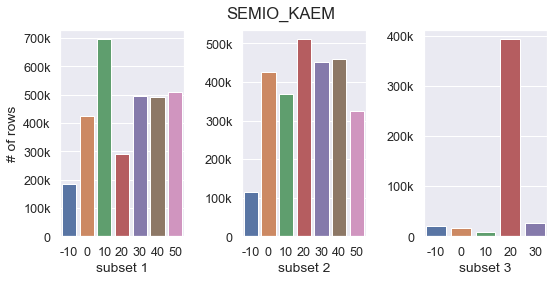

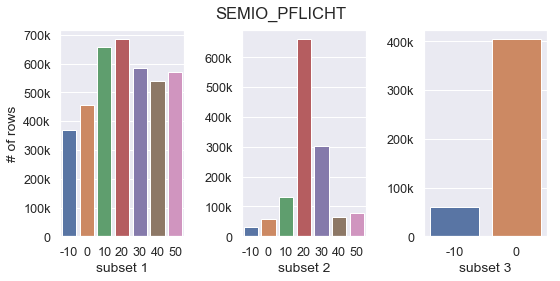

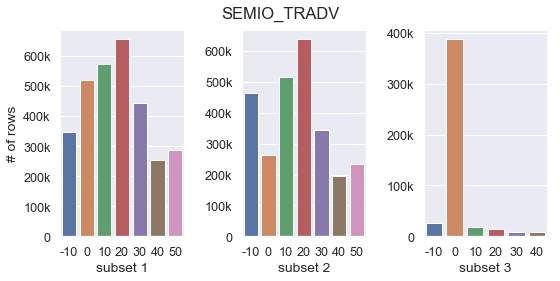

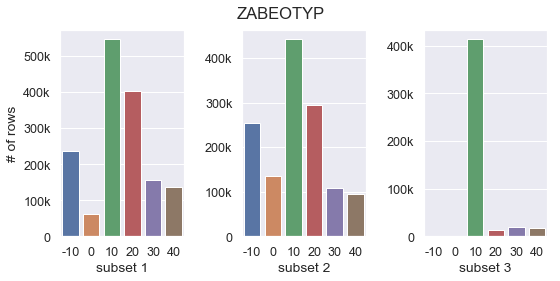

In [109]:
# Plot and contrast the distribution of categories  
# for all columns with no missing data:
df_1 = azdias.loc[(count_missing <= 8)]
df_2 = azdias.loc[(count_missing >= 9) & (count_missing <= 32)]
df_3 = azdias.loc[(count_missing > 32)]

for column_name in clean_cols:
    cat_distribution(df_1, df_2, df_3, column_name)

In [110]:
# As directed, I will continue the analysis using just the subset of
# the data with few or no missing values - i.e. missing features <= 8
azdias_1 = df_1.copy(deep=True)

#### Discussion of missing data per row

Histograms 3 and 4 show the distribution of missing values per row in the dataset. Histogram 4 is a zoomed-in version of Histogram 3 that excludes rows with no missing values. 

Histogram 4 shows that most rows with any missing values have at most 8 missing features. The count of rows declines almost consistently from 9 to 32 missing features. We see significant spikes in the count of rows starting again at 33 missing features. 

Based on this, I split the dataset into 3 subsets:
- Subset 1 : rows with `missing features <= 8` : 771,701
- Subset 2 : rows with `9 <= missing features <= 32` : 26,575
- Subset 3 : rows with `missing features > 32` : 92,945

In order to investigate if the distribution of data values on columns that are not missing data are similar between these subsets,  I identified the 24 columns with no missing values and plotted the distributions of values for each of these 24 columns. That is, contrasting each distribution side-by-side between the 3 subsets.

The plots show that for most columns with no missing values, the distributions are similar between *subset 1* and *subset 2* . However, the plots also show that the distributions of values in *subset 3* do look qualitatively different than the other two subsets. 

This visual comparisons suggests that keeping the rows in subset 1 (missing features <= 8) and dropping the rows in subset 2 should not present a major issue for our analysis of customer segments. On the other hand, subset 3 (missing features > 32) seems to be different from the other two subsets in a systematic way, which would imply that dropping those observations introduces bias into the analysis. 

That said, here I follow the project instructions and continue the analysis for now only using the subset of observations with 8 or fewer missing features.

### Re-encode categorical and mixed-type features

The tools included in `scikit-learn` for dimensionality reduction and clustering only work on data that is encoded numerically, so in this section I will make a few encoding changes and additional assumptions. While almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 

The third column of the `feat_info` DataFrame (feature summary) is a summary of the types of measurement in the main dataset. Using this information, the following objectives can be met:

1. Numeric and interval variables can be kept without changes.

2. Ordinal variables can be treated as being interval in nature (that is, kept without any changes). This is a simplifying assumption since ordinal variables do not necessarily represent fixed intervals. 

3. Categorical and mixed-type variables need to be re-encoded appropriately, if it's decided that they are useful and should be kept for the analysis.

First, let's count the features by type according to the `feat_info` DataFrame:

In [111]:
# Create counter of number of features/columns per type of measurement
feat_types = Counter(feat_info['type'])
print(feat_types)

Counter({'ordinal': 49, 'categorical': 21, 'numeric': 7, 'mixed': 7, 'interval': 1})


In [112]:
# Create dictionary to map feature types to feature/column names
feat_types = {}
for f_type in set(feat_info['type']):
    bool_idx = feat_info['type'] == f_type
    feat_types[f_type] = feat_info['attribute'][bool_idx].tolist()

The dictionary `reencoded_feats` keeps track of the column names, by mapping each original column name to the names of new columns generated by re-encoding the original.

In [113]:
# Create dictionary to track column/feature engineering
reencoded_feats = {}

In [114]:
# Helper function
def add_to_reencoded(reencoded_feats, original_feat, eng_feat_list):
    """Check if the names are already in reencoded_feats 
    and return updated version.
    
    Args: 
        reencoded_feats (dict): Mapping of original feature name to list 
            of new feature names.
        original_feat (str): Original feature name.
        eng_feat_list (list): String of re-encoded feature names.
    
    Returns: 
        reencoded_feats (dict): With added feature names if appropriate.
    
    """
    if not isinstance(eng_feat_list, list):
        print('Error: The new or engineered features should be in a list.')
        return None
    if original_feat not in reencoded_feats:
        reencoded_feats[original_feat] = eng_feat_list
        return reencoded_feats
    else:
        print('Warning: "{}" is already recorded.'.format(original_feat))
        for eng_feat in eng_feat_list:
            if eng_feat not in reencoded_feats[original_feat]:
                print('"{}" added to its re-encoded features.'\
                      .format(eng_feat))
                reencoded_feats[original_feat].append(eng_feat)
            else:
                continue
        return reencoded_feats

In [115]:
# Keep track of outlier columns from previous section
# Add to reencoded_feats
for feature in outliers:
    add_to_reencoded(reencoded_feats, feature, [])

#### Re-encode categorical features

First, I assess whether the categorical variables are binary or multi-level. Then I decide which ones need to be re-encoded.

In [116]:
# Create dictionary to map categoricals to their set of unique values
categoricals_values = {}

# Populate dictionary for all categoricals
for feature in feat_types['categorical']:
    if feature in azdias_1:
        categoricals_values[feature] = azdias_1[feature]\
            .dropna().unique().tolist()
    else:
        continue

# Print quantity of categoricals in original data
print('Number of categorical variables in working dataset: {}'\
      .format(len(categoricals_values)))

Number of categorical variables in working dataset: 18


In [117]:
# Create lists to split names of binary and multilevel categoricals
feat_types['binary'] = []
feat_types['multilevel'] = []

# Populate lists based on categoricals_values dictionary
for categorical, set_values in categoricals_values.items():
    if len(set_values) == 2:
        feat_types['binary'].append(categorical)
    elif len(set_values) > 2:
        feat_types['multilevel'].append(categorical)
        
# Print results
print('Number of binary categoricals in working dataset: {:>7}'\
      .format(len(feat_types['binary'])))
print('Number of multi-level categoricals in working dataset: {}'\
      .format(len(feat_types['multilevel'])))

Number of binary categoricals in working dataset:       5
Number of multi-level categoricals in working dataset: 13


In [118]:
# Investigate the type of values for each binary categorical
for feature in feat_types['binary']:
    print('Values in feature {}: \n {} \n'\
          .format(feature, categoricals_values[feature]))

Values in feature ANREDE_KZ: 
 [2.0, 1.0] 

Values in feature GREEN_AVANTGARDE: 
 [0, 1] 

Values in feature SOHO_KZ: 
 [1.0, 0.0] 

Values in feature VERS_TYP: 
 [2.0, 1.0] 

Values in feature OST_WEST_KZ: 
 ['W', 'O'] 



`OST_WEST_KZ` requires re-encoding since it takes non-numeric values. The rest of the binary, categorical variables do not need to be re-encoded.

In [119]:
# Set column names
original_feat = 'OST_WEST_KZ'
eng_feat = 'OST_WEST_KZ_num'

# Re-encode OST_WEST_KZ: 1 for 'W', 0 for 'O'
azdias_1.loc[:, eng_feat] = azdias_1[original_feat]\
    .apply(lambda x: 1 if x == 'W' else 0)

In [120]:
# Keep track of re-encoded binary categorical
# Add to reencoded_feats
add_to_reencoded(reencoded_feats, original_feat, [eng_feat])

{'AGER_TYP': [],
 'GEBURTSJAHR': [],
 'TITEL_KZ': [],
 'ALTER_HH': [],
 'KK_KUNDENTYP': [],
 'KBA05_BAUMAX': [],
 'OST_WEST_KZ': ['OST_WEST_KZ_num']}

#### Selection of categorical features

The feat_info table indicates that the original data includes 5 general types of measurements: 

- ordinal: 49 columns
- categorical: 21 columns
- numeric: 7 columns
- mixed: 7 columns
- interval: 1 column.

Out of the original 21 categoricals, 3 were dropped in a previous section due to large proportions of missing values. The remaining 18 categorical features are divided into multi-level, 13 columns, and binary, 5 columns.  

Here I follow the project recommendation for simplicity: drop the 13 multi-level categorical features and keep the binary features.

#### Re-encode mixed-type features

A handful of features are marked as "mixed" in the feature summary table. These require special treatment in order to be included in the analysis. 

According to the project instructions, two mixed-type features are known to be important and deserve particular attention:

- `"PRAEGENDE_JUGENDJAHRE"` combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I will create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.

- `"CAMEO_INTL_2015"` combines information on two axes: wealth and life stage. I will break up the two-digit codes into two new ordinal variables.

In [121]:
# Print quantity of mixed-type variables in original data
print('Number of mixed-type variables in original dataset: {}'\
      .format(len(feat_types['mixed'])))

Number of mixed-type variables in original dataset: 7


##### `"PRAEGENDE_JUGENDJAHRE"`

In [122]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
original_feat = 'PRAEGENDE_JUGENDJAHRE'

In [123]:
# Print set of unique values in "PRAEGENDE_JUGENDJAHRE"
feature_values = azdias_1[original_feat].dropna().unique().tolist()
print('Values in feature {}: \n {} \n'\
      .format(original_feat, feature_values))
print('Data types of elements: \n {}'\
      .format(set([type(x) for x in feature_values])))

Values in feature PRAEGENDE_JUGENDJAHRE: 
 [14.0, 15.0, 8.0, 3.0, 10.0, 11.0, 5.0, 9.0, 6.0, 4.0, 2.0, 1.0, 12.0, 13.0, 7.0] 

Data types of elements: 
 {<class 'float'>}


In [124]:
# Helper function
def decade(value):
    """Transform values from floats to integer in order to re-encode 
    the **decade** dimension of PRAEGENDE_JUGENDJAHRE.
    
    Args: 
        value (float)
    
    Returns: 
        (int)
        
    """
    if value in set([1.0, 2.0]):
        return 0
    elif value in set([3.0, 4.0]):
        return 1
    elif value in set([5.0, 6.0, 7.0]):
        return 2
    elif value in set([8.0, 9.0]):
        return 3
    elif value in set([10.0, 11.0, 12.0, 13.0]):
        return 4
    elif value in set([14.0, 15.0]):
        return 5
    else:
        return value

# Test function    
print(decade(10.0))

4


In [125]:
# Re-encode "PRAEGENDE_JUGENDJAHRE" - "decade" dimension
eng_feat_1 = 'PRAEGENDE_JUGENDJAHRE_decade'
azdias_1.loc[:, eng_feat_1] = azdias_1[original_feat].apply(decade)

In [126]:
# Helper function
def movement(value):
    """Transform value from float to binary object in order to re-encode 
    the **movement** dimension of PRAEGENDE_JUGENDJAHRE.
    
    Args: 
        value (float)
    
    Returns: 
        (int)
        
    """
    # Create two sets of values that separate the "movement" dimension
    mainstream = set([1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0])
    avantgarde = set([2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0])

    if value in avantgarde:
        return 1
    elif value in mainstream:
        return 0
    else:
        return value

In [127]:
# Re-encode "PRAEGENDE_JUGENDJAHRE" - "movement" dimension
eng_feat_2 = 'PRAEGENDE_JUGENDJAHRE_movement'
azdias_1.loc[:, eng_feat_2] = azdias_1[original_feat].apply(movement)

In [128]:
# Keep track of re-encoded mixed-type variables
# Add to reencoded_feats
add_to_reencoded(reencoded_feats, original_feat, [eng_feat_1, eng_feat_2]);

##### `"CAMEO_INTL_2015"`

In [129]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables
original_feat = 'CAMEO_INTL_2015'

In [130]:
# Print set of unique values in "CAMEO_INTL_2015"
feature_values = azdias_1[original_feat].dropna().unique().tolist()
print('Values in feature {}: \n {} \n'.format(
    original_feat, feature_values))
print('Data types of elements: \n {}'.format(
    set([type(x) for x in feature_values])))

Values in feature CAMEO_INTL_2015: 
 ['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'] 

Data types of elements: 
 {<class 'str'>}


In [131]:
# Re-encode "CAMEO_INTL_2015" - "wealth" dimension
eng_feat_1 = 'CAMEO_INTL_2015_wealth'
azdias_1.loc[:, eng_feat_1] = azdias_1[original_feat]\
    .apply(lambda x: int(x[0]) if isinstance(x, str) else x)

In [132]:
# Re-encode "CAMEO_INTL_2015" - "stage" dimension
eng_feat_2 = 'CAMEO_INTL_2015_stage'
azdias_1.loc[:, eng_feat_2] = azdias_1[original_feat]\
    .apply(lambda x: int(x[1]) if isinstance(x, str) else x)

In [133]:
add_to_reencoded(reencoded_feats, original_feat, [eng_feat_1, eng_feat_2]);

##### `"WOHNLAGE"`

In [134]:
# Investigate "WOHNLAGE" and engineer two new variables.
original_feat = 'WOHNLAGE'

In [135]:
# Print set of unique values in "WOHNLAGE"
feature_values = azdias_1[original_feat].dropna().unique().tolist()
print('Values in feature {}: \n {} \n'.format(
    original_feat, feature_values))
print('Data types of elements: \n {}'.format(
    set([type(x) for x in feature_values])))

Values in feature WOHNLAGE: 
 [4.0, 2.0, 7.0, 3.0, 5.0, 1.0, 8.0, 0.0] 

Data types of elements: 
 {<class 'float'>}


In [136]:
# Helper function
def neighborhood(value):
    """Re-encode the **neighborhood quality** dimension of WOHNLAGE.
    
    Args: 
        value (float)
    
    Returns: 
        (float)
        
    """
    if np.isnan(value): 
        return value
    if value in [1., 2., 3., 4., 5.]: 
        return value
    else: 
        return 0

# Test function    
print(neighborhood(8.0))

0


In [137]:
# Re-encode "WOHNLAGE" - "neighborhood quality" dimension
eng_feat_1 = 'WOHNLAGE_neighborhood'
azdias_1.loc[:, eng_feat_1] = azdias_1[original_feat].apply(neighborhood)

In [138]:
# Helper function
def rural(value):
    """Re-encodes the **rural flag** dimension of WOHNLAGE.
    
    Args: 
        value (float)
    
    Returns: 
        (int)
        
    """
    if np.isnan(value): 
        return value
    elif value == 7: 
        return 1
    elif value == 8: 
        return 2
    else: 
        return 0

# Test function    
print(rural(8.0))

2


In [139]:
# Re-encode "WOHNLAGE" - "rural flag" dimension
eng_feat_2 = 'WOHNLAGE_rural'
azdias_1.loc[:, eng_feat_2] = azdias_1[original_feat].apply(rural)

In [140]:
add_to_reencoded(reencoded_feats, original_feat, [eng_feat_1, eng_feat_2])

{'AGER_TYP': [],
 'GEBURTSJAHR': [],
 'TITEL_KZ': [],
 'ALTER_HH': [],
 'KK_KUNDENTYP': [],
 'KBA05_BAUMAX': [],
 'OST_WEST_KZ': ['OST_WEST_KZ_num'],
 'PRAEGENDE_JUGENDJAHRE': ['PRAEGENDE_JUGENDJAHRE_decade',
  'PRAEGENDE_JUGENDJAHRE_movement'],
 'CAMEO_INTL_2015': ['CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_stage'],
 'WOHNLAGE': ['WOHNLAGE_neighborhood', 'WOHNLAGE_rural']}

#### Selection of mixed-type features

For the handful of features that are marked as mixed-type in the feature summary, I also follow the project recommendations for simplicity; that is, I drop most of them and only re-encode and keep three in the analysis: `"PRAEGENDE_JUGENDJAHRE"`, `"CAMEO_INTL_2015"`, and `"WOHNLAGE"`.

- `"PRAEGENDE_JUGENDJAHRE"` is re-encoded into `"PRAEGENDE_JUGENDJAHRE_decade"` (multi-level) and `"PRAEGENDE_JUGENDJAHRE_movement"` (binary).

- `"CAMEO_INTL_2015"` is re-encoded into two multi-level categoricals: `"CAMEO_INTL_2015_wealth"` and `"CAMEO_INTL_2015_stage"`.

- `"WOHNLAGE"` is re-encoded into two multi-level categoricals: `"WOHNLAGE_neighborhood"` and `"WOHNLAGE_rural"`. 

### Finalize feature selection

The assumptions and decisions thus far imply that the DataFrame to be used for the main analysis should consist of the following:

- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Re-encoded features from other multi-level categorical features and mixed features.

#### Select all numeric, interval, and ordinal features

In [141]:
# Create empty list to keep track of feature selection 
feature_selection = list()

# Append all numeric, interval, and ordinal type columns
# from the original dataset
for f_type in ['numeric', 'interval', 'ordinal']:
    for f_name in feat_types[f_type]:
        feature_selection.append(f_name)

# Print feature selection
print('Number of features selected so far: {}'.format(
    len(feature_selection)))

Number of features selected so far: 57


#### Select all binary features

In [142]:
# Append binary type columns 
for f_name in feat_types['binary']:
    feature_selection.append(f_name)

# Print feature selection
print('Number of selected binary categoricals: {}'.format(
    len(feat_types['binary'])))
print('Number of features selected so far:    {}'.format(
    len(feature_selection)))

Number of selected binary categoricals: 5
Number of features selected so far:    62


#### Select all new, re-encoded features

In [143]:
# Append new re-encoded columns 
count = 0
for list_new_f in reencoded_feats.values():
    for f_name in list_new_f:
        feature_selection.append(f_name)
        count += 1

# Print feature selection
print('Number of newly encoded variables:   {}'.format(count))
print('Number of features selected so far: {}'.format(
    len(feature_selection)))

Number of newly encoded variables:   7
Number of features selected so far: 69


#### Remove the original features that were re-encoded

In [144]:
# Drop original features that were re-encoded 
# or removed due to missing data
feature_selection = [feature for feature in feature_selection 
                     if feature not in reencoded_feats.keys()]

# Print feature selection
print('Number of features selected so far: {}'.format(
    len(feature_selection)))

Number of features selected so far: 66


#### Create a new DataFrame based on the feature selection

In [145]:
# Make list of features to drop from working dataset
drop_list = [col for col in azdias_1.columns.tolist() 
             if col not in feature_selection]

# Drop columns from azdias_1 to get the clean, engineered dataset
azdias_eng = azdias_1.drop(inplace=False, axis=1, labels=drop_list)

In [146]:
# Print dimensions of working dataset
print('Shape of dataset after feature selection: {:,} x {}'.format(
    azdias_eng.shape[0], azdias_eng.shape[1]))

Shape of dataset after feature selection: 771,701 x 66


### Create a data preprocessing function

All the data preprocessing steps executed above for the population data will be conducted later on the customer demographics data. So in this section, I create a function to execute the main feature selection, encoding, and re-engineering steps above.

In [147]:
def clean_data(df, feature_selection):
    """Perform feature trimming (of missing data), re-encoding, and 
    engineering for demographics data.
    
    Args: 
        df (DataFrame): Demographics DataFrame.
        feature_selection (list): Features/columns to be kept for the 
            clustering analysis.
    
    Returns: 
        Trimmed and cleaned demographics DataFrame.
        
    """
    # (1) Convert missing-value codes into NaNs
    
    for feature in df:
        # Retrieve list of codes for missing values from feat_info
        bool_idx = feat_info['attribute'] == feature
        nan_codes = feat_info.loc[bool_idx, 'missing_codes'].iloc[0] 
        # Iterate through list of codes
        for code in nan_codes:
            if code == '': 
                continue
            # Transform code from string to integer 
            if code.isnumeric() or code.lstrip('-').isnumeric():
                code = int(code)
            # Replace coded values in azdias dataframe with numpy NaN
            bool_idx = df[feature] == code
            df.loc[bool_idx, feature] = np.nan
    
    # (2) Remove rows with 9 or more missing features
    
    count_missing = df.isnull().sum(axis=1)
    bool_idx = (count_missing <= 8)    
    df = df[bool_idx]
    
    # (3) Re-encode non-numeric features

    # Re-encode OST_WEST_KZ: 1 for 'W', 0 for 'O'
    df.loc[:, 'OST_WEST_KZ_num'] = df['OST_WEST_KZ']\
        .apply(lambda x: 1 if x == 'W' else 0)
    
    # Re-encode "PRAEGENDE_JUGENDJAHRE"
    # "decade" dimension
    df.loc[:, 'PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE']\
        .apply(decade)
    # "movement" dimension
    df.loc[:, 'PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE']\
        .apply(movement)
    
    # Re-encode "CAMEO_INTL_2015"
    # "wealth" dimension
    df.loc[:, 'CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015']\
        .apply(lambda x: int(x[0]) if isinstance(x, str) else x)
    # "stage" dimension
    df.loc[:, 'CAMEO_INTL_2015_stage'] = df['CAMEO_INTL_2015']\
        .apply(lambda x: int(x[1]) if isinstance(x, str) else x)
    
    # Re-encode "WOHNLAGE"
    original_feat = 'WOHNLAGE'
    # "neighborhood" dimension
    df.loc[:, 'WOHNLAGE_neighborhood'] = df['WOHNLAGE'].apply(neighborhood)
    # "rural" dimension
    df.loc[:, 'WOHNLAGE_rural'] = df['WOHNLAGE'].apply(rural)

    # (4) Return the clean dataframe

    # Make list of features to drop from working dataset
    drop_list = [col for col in df.columns.tolist() 
                 if col not in feature_selection]
    
    # Drop all columns not in the feature_selection list
    df.drop(inplace=True, axis=1, labels=drop_list)
    return df 

---
## Impute missing values and standardize features

### Fit a feature scaler

Before applying dimensionality reduction to the data, I will perform feature scaling so that the principal-component vectors are not influenced by the natural differences in scale for features. 

But first, since the tools in `sklearn` do not work with NaN values, I will temporarily drop the observations with missing data in order to fit the tool [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [148]:
# Instantiate and fit the scaler model
scaler = StandardScaler().fit(azdias_eng.dropna(axis='index', inplace=False))

/Users/JCLH/miniconda3/envs/datascientist-nd/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


### Impute missing values

Here I rely on [`sklearn.impute.SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace NaNs with the feature median statistic.

In [150]:
# Apply imputation to population demographics data dataset
imputer = SimpleImputer(strategy="median")
azdias_imp = imputer.fit_transform(azdias_eng)

### Standardize features

Now that I have transformed the data using `SimpleImputer` and there are no NaNs in the DataFrame, I can standardize the features using the previously fitted `StandardScaler`.

I decided to temporarily remove missing values in order to fit the scaler to remove the influence of imputed missing values on the calculation of the distribution of features.

In [151]:
# Apply feature scaling to population data with imputed values
azdias_scaled = scaler.transform(azdias_imp)

---
## Apply dimensionality reduction (PCA)

In this section I will apply dimensionality reduction techniques on the standardized data. Specifically, I will use [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to apply principal component analysis, thus finding the vectors of maximal variance in the data. 

Main goals of this section:

1. Assess the variance explained by each principal component as well as the cumulative variance explained. Plot the cumulative or sequential values. 

2. Select a value for the number of transformed features to retain, `n_components`, for the clustering part of the project.

3. Re-fit a PCA instance to perform the transformation retaining the chosen number for `n_components`.

### Assess variance explained by each principal component 

In [152]:
# Instantiate, fit and transform using PCA. No dimensionality reduction.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)
print('Shape of azdias_pca: {:,} x {}'\
      .format(azdias_pca.shape[0], azdias_pca.shape[1]))

Shape of azdias_pca: 771,701 x 66


In [153]:
# Visualize the variance accounted for by each principal component
def scree_plot(pca, num_components='all'):
    """Create a scree plot to show the variance accounted for 
    by each principal component.
    
    Args: 
        pca: Output of PCA fit_transform() in scikit-learn.
        num_components (int, str='all')
    
    """
    if num_components == 'all':
        num_components = len(pca.explained_variance_ratio_)
    
    # Get data values
    # x axis:
    x_axis = np.arange(num_components)[0:num_components] 
    # Explained variance:
    values = pca.explained_variance_ratio_[0:num_components] 
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=(18, 6))
    
    # Bars of variance per principal component
    ax1.bar(x_axis, values, color='c')
    
    # Annotate bars
    for i in range(num_components):
        ax1.annotate('{:.2%}'.format(values[i]), (x_axis[i], values[i]+1/500),
                     rotation=90, va="bottom", ha="center", fontsize=12)
    
    # Plot of cumulative variance
    ax2 = ax1.twinx()
    ax2.plot(x_axis, np.cumsum(values), color='r')
    
    # Set parameters for x-axis
    ax1.set_xlim(0-0.5,num_components-0.5)
    ax1.xaxis.set_tick_params(width=0)
    ax1.xaxis.set_major_locator(
        ticker.MaxNLocator(nbins=num_components, integer=True))
    ax1.set_xlabel("Principal component")
    
    # Set parameters for left y-axis
    ax1.set_ylim([n*1.1 for n in ax1.get_ylim()])
    ax1.yaxis.set_major_locator(ticker.FixedLocator(np.arange(0,30,2)/100))
    
    # Set parameters common for both y-axis
    for pos, ax in enumerate([ax1, ax2]):
        ax.grid(b=False, which='major', axis='both')
        ax.yaxis.set_major_formatter(
            ticker.PercentFormatter(xmax=1, decimals=0))
        ax.yaxis.set_tick_params(width=2, length=8, color=['c','r'][pos])
        ax.set_ylabel(["Ratio of variance explained (%)",
                      "Cumulative variance explained (%)"][pos])
        
    # Set title 
    plt.title('Explained variance per principal component (PCA)',
              fontweight='bold', fontsize=16)

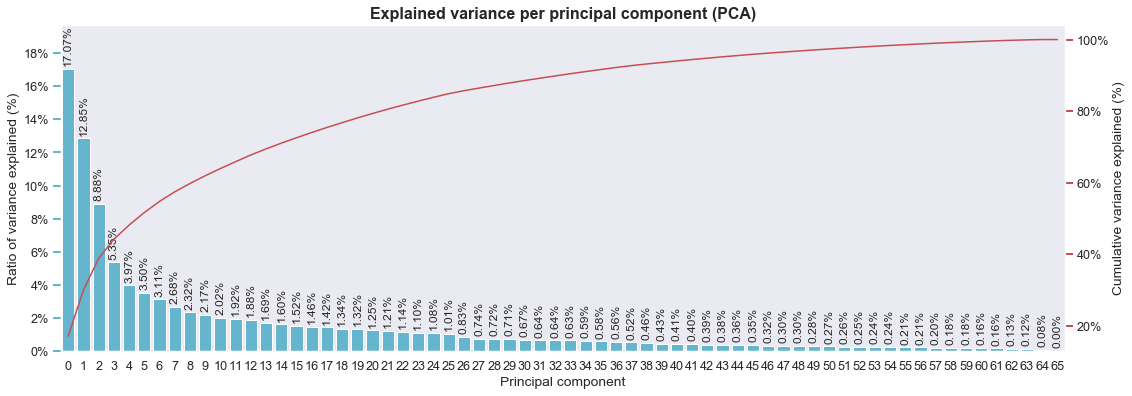

In [155]:
# Scree plot for full set of principal components
scree_plot(pca, num_components='all')

To create the scree plot above, I use and modify the code provided in the `helper_functions.py` Udacity module. The left axis in the figure is associated with the bars — ratio of variance explained by each component — while the right axis corresponds to the cumulative variance, plotted using the red curve. 

The plot shows that the "elbow" of the variance-explained curve is not clearly identified; in other words, the marginal variance-explained declines gradually, with no significant inflection point that would provide one clear choice for number of PCA components (if one were using the marginal variance-explained criterion).

Hereafter I'm following my project-reviewer's recommendation by choosing 40 principal components, which retains more than 90% of the variance; as seen in the scree plot.

### Transform data keeping 40 principal components

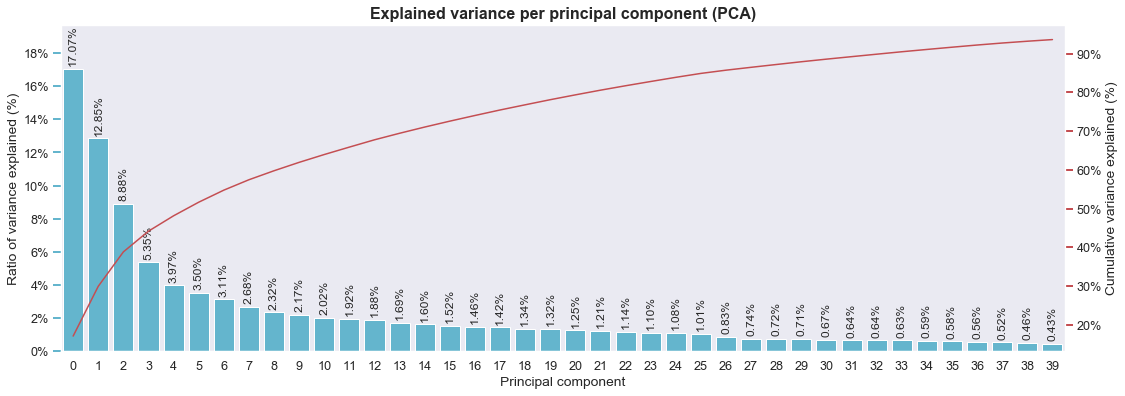

In [156]:
# Scree plot for the first 40 principal components
scree_plot(pca, num_components=40)

In [157]:
# Re-apply PCA to the data, retaining 40 components
pca_40 = PCA(n_components=40)
azdias_40 = pca_40.fit_transform(azdias_scaled)

print('Shape of azdias_pca_40: {:,} x {}'.format(
        azdias_40.shape[0], azdias_40.shape[1]))

Shape of azdias_pca_40: 771,701 x 40


### Interpret principal components

Each principal component is a unit vector that points in the direction of highest variance, after accounting for the variance captured by earlier principal components. The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

The function below maps weights for a principal component to the corresponding feature names; and then prints the linked values, sorted by weight.

In [158]:
def pca_results(dataset, pca, nth_component=1):
    """Map weights for a principal component to corresponding feature 
    names; and then print the linked values, sorted by weight.
    
    Args:  
        dataset (Pandas DataFrame): Data before scikit-learn 
            transformations.
        pca (sklearn.decomposition.pca.PCA): Result of PCA fit.
        nth_component (int): Number of principal component to assess.
    
    Returns: 
        None
    
    """
    # nth_component indexing
    suffix = {1:'st', 2:'nd', 3:'rd'}
    component_index = ['{}{}'.format(i, suffix.get(i, 'th'))
                       for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), 
                              columns=dataset.keys())
    components.index = component_index
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    var_ratios = pd.DataFrame(np.round(ratios, 4), 
                              columns=['Explained Variance'])  
    var_ratios.index = component_index
    
    label = '{}{}'.format(nth_component, suffix.get(nth_component,'th'))
    weights = components.loc[label,]
    sorted_weights = weights.loc[weights.abs()\
                                 .sort_values(ascending=False).index]
    
    # Print the mapping in list form
    first_n_feat = 30
    print('— {} PRINCIPAL COMPONENT —'.format(label))
    print('\nExplained variance: {}'.format(var_ratios.loc[label][0]))
    print('\n{} most prominent features by weight:'.format(first_n_feat))
    print(sorted_weights.iloc[0:first_n_feat])
                  
    return None

In [159]:
# Map weights for the **FIRST principal component**
pca_results(azdias_eng, pca_40, nth_component=1)

— 1st PRINCIPAL COMPONENT —

Explained variance: 0.1707

30 most prominent features by weight:
MOBI_REGIO                       -0.2352
PLZ8_ANTG3                        0.2275
PLZ8_ANTG1                       -0.2215
PLZ8_ANTG4                        0.2175
KBA05_GBZ                        -0.2116
KBA05_ANTG1                      -0.2115
ORTSGR_KLS9                       0.2105
EWDICHTE                          0.2087
CAMEO_INTL_2015_wealth            0.2042
FINANZ_MINIMALIST                -0.2028
HH_EINKOMMEN_SCORE                0.2017
WOHNLAGE_neighborhood             0.1810
WOHNLAGE_rural                   -0.1731
KONSUMNAEHE                      -0.1730
INNENSTADT                       -0.1698
FINANZ_HAUSBAUER                  0.1692
PLZ8_GBZ                         -0.1644
PLZ8_ANTG2                        0.1567
KBA05_ANTG4                       0.1523
ARBEIT                            0.1499
RELAT_AB                          0.1421
ANZ_HAUSHALTE_AKTIV               0.1377
KBA

In [160]:
# Map weights for the **SECOND principal component**
pca_results(azdias_eng, pca_40, nth_component=2)

— 2nd PRINCIPAL COMPONENT —

Explained variance: 0.1285

30 most prominent features by weight:
ALTERSKATEGORIE_GROB            0.2705
SEMIO_REL                      -0.2697
PRAEGENDE_JUGENDJAHRE_decade   -0.2610
FINANZ_SPARER                  -0.2568
FINANZ_VORSORGER                0.2450
FINANZ_UNAUFFAELLIGER          -0.2391
SEMIO_TRADV                    -0.2351
SEMIO_ERL                       0.2348
SEMIO_PFLICHT                  -0.2345
FINANZ_ANLEGER                 -0.2204
SEMIO_KULT                     -0.2196
SEMIO_LUST                      0.1892
SEMIO_FAM                      -0.1861
SEMIO_RAT                      -0.1792
RETOURTYP_BK_S                  0.1674
SEMIO_MAT                      -0.1655
ONLINE_AFFINITAET              -0.1578
W_KEIT_KIND_HH                  0.1117
SEMIO_KRIT                      0.1094
SEMIO_SOZ                      -0.1024
FINANZ_MINIMALIST               0.0996
SEMIO_KAEM                      0.0988
FINANZ_HAUSBAUER                0.0948
MIN_GEBA

In [161]:
# Map weights for the **THIRD principal component**
pca_results(azdias_eng, pca_40, nth_component=3)

— 3rd PRINCIPAL COMPONENT —

Explained variance: 0.0888

30 most prominent features by weight:
ANREDE_KZ                        -0.3723
SEMIO_VERT                        0.3533
SEMIO_KAEM                       -0.3317
SEMIO_DOM                        -0.3060
SEMIO_KRIT                       -0.2762
SEMIO_SOZ                         0.2654
SEMIO_FAM                         0.2520
SEMIO_KULT                        0.2371
SEMIO_RAT                        -0.2089
FINANZ_ANLEGER                   -0.1929
SEMIO_ERL                        -0.1806
FINANZ_MINIMALIST                 0.1661
RETOURTYP_BK_S                    0.1066
FINANZ_SPARER                    -0.1056
PRAEGENDE_JUGENDJAHRE_decade     -0.1013
FINANZ_VORSORGER                  0.0974
FINANZ_UNAUFFAELLIGER            -0.0954
W_KEIT_KIND_HH                    0.0836
SEMIO_REL                         0.0773
ALTERSKATEGORIE_GROB              0.0733
SEMIO_PFLICHT                    -0.0723
SEMIO_TRADV                      -0.0721
SEM

**— 1st PRINCIPAL COMPONENT —**

The first principal component includes large weights for correlated regional features that are associated with type of dwelling and density of population. For instance, `PLZ8_ANTG1` (number of 1-2 family houses in the PLZ8 region) and `PLZ8_ANTG3` (number of 6-10 family houses in the PLZ8 region) have similar weights with opposing directions, which indicate that whether an individual lives in a region with mostly single-/dual-family housing versus multi-family housing captures a large portion of the variance in our data. Other features like `KBA05_GBZ` (number of buildings in the microcell) and `EWDICHTE` (density of households) are similarly important regional features in the first principal component. 

But the first principal component also involves contributions from features at the person and household levels, which are directly associated with financial status; `FINANZ_MINIMALIST` (low financial interest) and `FINANZ_HAUSBAUER` (home ownership) have similar weights in opposing directions. `HH_EINKOMMEN_SCORE` (estimated household income) and `CAMEO_INTL_2015_wealth` (average household wealth) have similar weights in the same direction. 

I'd conclude that the first principal component is dominated by regional features that vary significantly between urban and suburban areas — as well as person- and household-level financial measurements that vary significantly within the range of income levels.  

**— 2nd PRINCIPAL COMPONENT —**

The second principal component shows large weights for many of the features that measure the given personality typology; for instance, all of the following have similar weights in the same direction: `SEMIO_REL` (religious), `SEMIO_PFLICHT` (dutiful), `SEMIO_TRADV` (traditional-minded), `SEMIO_FAM` (family-minded), and others.

This component also shows large weights for the person-level financial typology (`FINANZ_`) and for the features asscoiated with estimated age: `ALTERSKATEGORIE_GROB` and `PRAEGENDE_JUGENDJAHRE_decade`.

This leads me to infer that after accounting for the variance in regional features, explained by the first principal component, the second principal component is mostly capturing demographic and financial variance at the person and household levels.

**— 3rd PRINCIPAL COMPONENT —**

The third principal component's largest weight is for the gender feature, `ANREDE_KZ`. It also shows large weights for other features involved in the given personality typology; for instance, `SEMIO_VERT` (dreamful), `SEMIO_KAEM` (combative attitude), and `SEMIO_DOM` (dominant-minded).

I conclude that after accounting for the variance in regional features (explained by the first principal component) and the variance in person-level demographic and financial features (explained by the second principal component) the third principal component is dominated by features at the person level which vary more uniformly in the population.

---
## Clustering: Separate data in groups of equal variance

The demographics data has been explored and cleaned, then scaled, and transformed using dimensionality reduction (PCA). 

Now, it's time to see how the data clusters in the reduced, principal-components space. 

### Select the number of clusters to form 

The function below takes the dataset after being transformed for dimensionality reduction, and perform K-means clustering repeatedly for a sequence of cluster counts. Then, for each K-means model, it calculates the inertia (i.e., sum of squared distances of all samples to their closest cluster center) and the corresponding average distance.

In [170]:
def clusters_distances(data_pca, max_clusters):
    """Perform K-means clustering repeatedly on a dataset for a sequence 
    of cluster counts up to the argument 'max_clusters'.
    
    For each K-means model, calculate the inertia (sum of squared 
    distances of all samples to their closest cluster center) and the 
    corresponding average distance.
    
    Args:  
        data_pca (numpy.ndarray): Transformed data using PCA in sklearn.
        max_clusters (int): Max number of clusters to investigate. 
    
    Returns: 
        clusters (list): Sequence of clusters numbers to `max_clusters`.
        distances (list): Average distances to cluster centers by model.
    
    """
    
    # Instantiate list of clusters and distances
    clusters = list(range(1, max_clusters+1))
    distances = []

    for n_clusters in clusters:
        
        # Fit KMeans model
        model = KMeans(n_clusters).fit(X=data_pca)

        # Get attribute 'inertia_': 
        # sum of sq distances to closest cluster center
        inertia = model.inertia_
        
        # Get average distance
        ave_distance = np.sqrt(inertia / data_pca.shape[0])
        distances.append(ave_distance)
    return clusters, distances

In [180]:
def scree_kmeans(clusters, distances):
    """For a sequence of possible cluster totals, display display the 
    average distance of samples to closest cluster center.
    
    Args: 
        clusters (list): Sequence of clusters numbers to `max_clusters`.
        distances (list): Average distances to cluster centers by model.
    
    Returns:
        None
    
    """
    # Build list of labels to equal subset of 'distance' values
    distances_dict = {c: distances[c - 1] for c in clusters 
                      if (c <= 9 or c % 3 == 0)}
    labels = [distances_dict.get(c, '') for c in clusters]
    labels = [lab if isinstance(lab, str) else str(lab)[0:4] for lab in labels]
    
    # Build scree plot
    plt.figure(figsize=(8,6))
    plt.plot(clusters, distances,'ro--')
    plt.xticks(clusters)
    plt.yticks(distances, labels, fontsize=8)
    plt.xlabel('K: cluster count')
    plt.ylabel('Average within-cluster distance')
    plt.title('Average distance vs. cluster count')
    plt.grid(which='major', axis='y', linestyle='--')
    plt.show()
    return None

In [181]:
# Warning: Executing `clusters_distances()` may take a very long time
#clusters, distances = clusters_distances(data_pca=azdias_40, max_clusters=15)

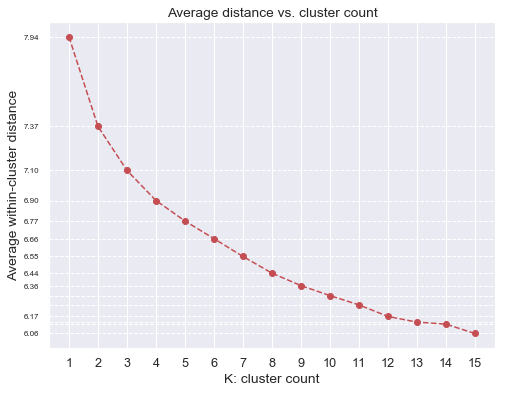

In [182]:
# Show scree plot 
scree_kmeans(clusters, distances)

### Apply K-means algorithm to general population data

Based on the plot shown above, I choose to segment the population into 14 clusters. I originally intended to apply the *elbow* strategy to find the optimal number of clusters, but these principal-components data do not show a clear inflection point at which adding new clusters no longer creates a substantial decrease in the average distance. 

The curve does show a clear downward trajectory of the marginal improvement in average distance, which becomes more stable in the range of 13 to 15 clusters.

In [183]:
# Instantiate model with the selected number of clusters
kmeans_13 = KMeans(n_clusters=13)

# Fit the model to PCA-fitted data
kmeans_13 = kmeans_13.fit(X=azdias_40)

# Predict labels on the same general population data
labels = kmeans_13.predict(X=azdias_40)

---
## Pre-process, transform, and cluster the customer data

Now that I have clusters and cluster centers for the general population, I can assess how the customer data maps onto those clusters. For this purpose, instead of re-fitting all of the models to the customer data, I will use the existing algorithm estimations (based on the the general population data) to clean, transform, and cluster the customer data.

In [184]:
# Load in the customer demographics data
filepath = 'Udacity_CUSTOMERS_Subset.csv'
customers = pd.read_csv(filepath, sep=';', quotechar='"')

In [186]:
# Print shape of customers 
print('Shape of {}: {:,} x {} \n'\
      .format(filepath, customers.shape[0], customers.shape[1]))
# Print first rows
print('First few rows of {}:'.format(filepath))
customers.head()

Shape of Udacity_CUSTOMERS_Subset.csv: 191,652 x 85 

First few rows of Udacity_CUSTOMERS_Subset.csv:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [188]:
# Apply preprocessing with cleaning function
customers = clean_data(customers, feature_selection)

/Users/JCLH/miniconda3/envs/datascientist-nd/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/JCLH/miniconda3/envs/datascientist-nd/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/JCLH/miniconda3/envs/datascientist-nd/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [189]:
# Print shape of clean customers dataset 
print('Shape of clean customers dataset: {:,} x {}'\
      .format(customers.shape[0], customers.shape[1]))

Shape of clean customers dataset: 128,298 x 66


In [190]:
# Apply feature scaling to the customers data
customers_imp = imputer.transform(customers)
customers_scaled = scaler.transform(customers_imp)

In [191]:
## Transform "customers_scaled" using fitted PCA
customers_40 = pca_40.transform(customers_scaled)

In [192]:
## Predict k-means labels on the customer data
labels_customers = kmeans_13.predict(customers_40)

---
## Clustering in the general population vs. the customer base

In the final section of this project, I will compare the two cluster distributions — the company's customer base vs. the general population — and discuss the business implications of the analysis.

### Compare the proportions of individuals per cluster

In order to compare and contrast the general population and the customer base, we mainly focus on the proportions of people in each cluster across the two datasets. If one believes that the company's customer base is a random, representative selection of the general population, then the cluster proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch in the clustering predictions between the two datasets. 

In the case of clustering mismatch, we can start building theories about systematic differences between the customer base and the general population. This theories, backed by this evidence, can lead to more effective marketing efforts. For example, if there is a higher proportion of people in a cluster for the customer data compared to the general population, then that suggests the people in that cluster may be a target audience for the company. 

In [193]:
# Compute proportion of data in each cluster for the general population
clustered_population = {}
n_pop = len(labels)
for label in set(labels):
    clustered_population[label] = sum(labels == label) / n_pop

In [194]:
# Compute  proportion of data in each cluster for the customer data
clustered_customers = {}
n_cust = len(labels_customers)
for label in set(labels_customers):
    clustered_customers[label] = sum(labels_customers == label) / n_cust

In [195]:
# Print the proportions side-by-side
diff_pp = []
print('             Population | Customers')
for label in clustered_population.keys():
    pop_pc = int(round(clustered_population[label]*100))
    cust_pc = int(round(clustered_customers[label]*100))
    diff_pp += [cust_pc - pop_pc]
    print('Cluster {:3.0f}:       {:>3.0f}% |{:>3.0f}%'\
          .format(label, pop_pc, cust_pc))

             Population | Customers
Cluster   0:         8% |  1%
Cluster   1:         7% | 12%
Cluster   2:         9% |  7%
Cluster   3:        10% |  7%
Cluster   4:        10% |  9%
Cluster   5:         5% |  3%
Cluster   6:         9% | 17%
Cluster   7:        10% |  1%
Cluster   8:         5% |  4%
Cluster   9:         7% | 34%
Cluster  10:        10% |  1%
Cluster  11:         7% |  1%
Cluster  12:         4% |  2%


Based on the table above, we can conclude that there is a clear mismatch in the proportions of people across clusters in the population and customers datasets. 

The function below allows us to visualize these differences using bar charts.

In [204]:
# Helper function
def labels_distribution(labels_population, labels_customers):
    """Plot the proportions of data in each cluster — contrasting the 
    general population and customers datasets
    
    Args: 
        labels_population (list): K-means predictions for population.
        labels_customers (list): K-means predictions for customer base.
        
    Returns: 
        None

    """
    fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(8,8))
    
    population = {'labels':labels_population, 
                  'axis':ax1,
                  'xlabel':"General population"}
    customers = {'labels':labels_customers, 
                  'axis':ax2,
                  'xlabel':"Customers"}    
    
    for data_dict in [population, customers]:
        df = pd.DataFrame(dict(labels=data_dict['labels']))
        sns.barplot(ax=data_dict['axis'], data=df, x="labels", y="labels", 
                    estimator=lambda x: len(x) / len(df) * 100)
        data_dict['axis'].set( xlabel=data_dict['xlabel'],
                               ylabel="Proportion") 
        data_dict['axis'].grid(which='major', axis='y')

    fig.suptitle('Proportion of data in each cluster')
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()
    return None

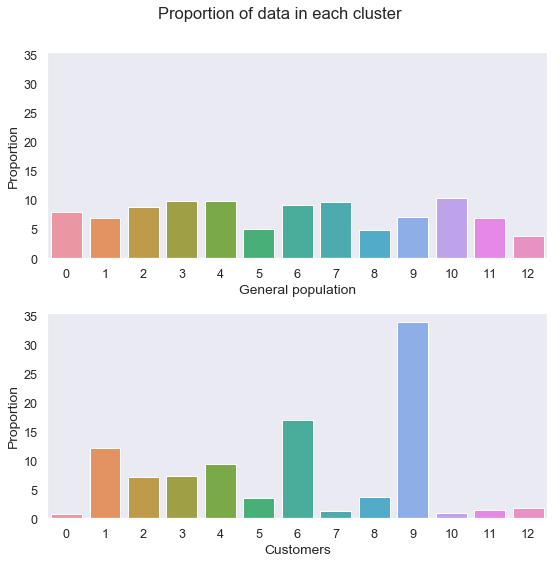

In [205]:
# Plot the proportion of data in each cluster 
# for the general population and the customers 
labels_distribution(labels, labels_customers)

The differences between cluster cannot be interpreted by only looking at the cluster centers, since the PCA algorithm transformed the data into a reduced dimension space. Therefore, in order to interpret this clusters I need to find the cluster centers in the PCA space and then perform an *inverse transform* from the PCA space to the scaled data and then to the original units of measurement. 

### Compare mismatching clusters in the original feature space

In [206]:
# Use inverse_transform() method of PCA and StandardScaler objects 
# to transform centroids back to the original data space
centroids = kmeans_13.cluster_centers_
centroids = pca_40.inverse_transform(centroids)
centroids = scaler.inverse_transform(centroids)

Now that the cluster centers have been transformed to the original units of measurement, I can compare different clusters in terms of the average values of the original features in the datasets.  

In [218]:
def centroid_values(features, centroids, diff_proportions,
                    over_cluster, under_cluster):
    """Print average feature values in the original space for selected
    clusters.
    
    Args: 
        features (array): Features/colums to print out.
        centroids (array): Centroid values in the original space.
        diff_proportions (list): Proportion in customer base minus 
            proportion in general population, for all clusters.
        over_cluster (int): Overrepresented cluster in customer data.
        under_cluster (int): Underrepresented cluster in customer data.
    
    Returns: 
        None. Prints pair of feature name and value.
    
    """
    pp_1 = diff_proportions[over_cluster]
    pp_2 = diff_proportions[under_cluster]
    print('{0:>30}  {1:>20}'.format('-Feature-', '-Cluster centroids-'))
    print('{0:>30} |   ({1:>+d})|    ({2:>+d})|'.format('', pp_1, pp_2))
    for ii in zip(features, centroids[over_cluster], centroids[under_cluster]):
        print('{0:>30} |{1:>8.1f}|{2:>8.1f}|'.format(ii[0], ii[1], ii[2]))
    return None

Using the function `centroid_values()` I will assess 4 pairs of mismatching clusters, to hopefully provide a reliable answer to the following question:

> **What important demographic features separate people in clusters that are overrepresented in the customer data compared to the general population?**

For all comparisons below, I use Cluster \#9 as the benchmark, overrepresented cluster in the customers dataset. The proportion of people in Cluster \#9 is 27 percentage points higher in the customer base compared to the general population (34\% vs. 7\%).

In [225]:
# Overrepresent  Cluster 9: 34% in customers vs.  7% in population
# Underrepresent Cluster 7:  1% in customers vs. 10% in population

centroid_values(features=customers.columns, diff_proportions=diff_pp,
                centroids=centroids, over_cluster=9, under_cluster=7)

                     -Feature-   -Cluster centroids-
                               |   (+27)|    (-9)|
          ALTERSKATEGORIE_GROB |     3.3|     1.8|
                     ANREDE_KZ |     1.0|     2.0|
             FINANZ_MINIMALIST |     4.8|     2.2|
                 FINANZ_SPARER |     1.6|     4.0|
              FINANZ_VORSORGER |     4.2|     2.3|
                FINANZ_ANLEGER |     1.4|     4.4|
         FINANZ_UNAUFFAELLIGER |     2.1|     3.9|
              FINANZ_HAUSBAUER |     2.0|     3.1|
              GREEN_AVANTGARDE |     1.0|     0.2|
                    HEALTH_TYP |     2.1|     2.2|
                RETOURTYP_BK_S |     4.0|     2.5|
                     SEMIO_SOZ |     4.9|     2.7|
                     SEMIO_FAM |     4.7|     3.7|
                     SEMIO_REL |     3.7|     5.2|
                     SEMIO_MAT |     3.9|     4.9|
                    SEMIO_VERT |     6.3|     2.6|
                    SEMIO_LUST |     5.4|     3.4|
                     SEMIO_ER

In [220]:
# Overrepresent  Cluster  9: 34% in customers vs.  7% in population
# Underrepresent Cluster 10:  1% in customers vs. 10% in population

centroid_values(features=customers.columns, diff_proportions=diff_pp,
                centroids=centroids, over_cluster=9, under_cluster=10)

                     -Feature-   -Cluster centroids-
                               |   (+27)|    (-9)|
          ALTERSKATEGORIE_GROB |     3.3|     1.7|
                     ANREDE_KZ |     1.0|     2.0|
             FINANZ_MINIMALIST |     4.8|     1.2|
                 FINANZ_SPARER |     1.6|     4.3|
              FINANZ_VORSORGER |     4.2|     2.2|
                FINANZ_ANLEGER |     1.4|     4.1|
         FINANZ_UNAUFFAELLIGER |     2.1|     3.8|
              FINANZ_HAUSBAUER |     2.0|     4.2|
              GREEN_AVANTGARDE |     1.0|     0.0|
                    HEALTH_TYP |     2.1|     2.2|
                RETOURTYP_BK_S |     4.0|     2.6|
                     SEMIO_SOZ |     4.9|     3.2|
                     SEMIO_FAM |     4.7|     4.1|
                     SEMIO_REL |     3.7|     5.5|
                     SEMIO_MAT |     3.9|     4.8|
                    SEMIO_VERT |     6.3|     2.3|
                    SEMIO_LUST |     5.4|     3.1|
                     SEMIO_ER

In [223]:
# Overrepresent  Cluster 9: 34% in customers vs. 7% in population
# Underrepresent Cluster 0:  1% in customers vs. 8% in population

centroid_values(features=customers.columns, diff_proportions=diff_pp,
                centroids=centroids, over_cluster=9, under_cluster=0)

                     -Feature-   -Cluster centroids-
                               |   (+27)|    (-7)|
          ALTERSKATEGORIE_GROB |     3.3|     1.8|
                     ANREDE_KZ |     1.0|     1.0|
             FINANZ_MINIMALIST |     4.8|     1.9|
                 FINANZ_SPARER |     1.6|     4.4|
              FINANZ_VORSORGER |     4.2|     2.1|
                FINANZ_ANLEGER |     1.4|     3.6|
         FINANZ_UNAUFFAELLIGER |     2.1|     3.8|
              FINANZ_HAUSBAUER |     2.0|     3.6|
              GREEN_AVANTGARDE |     1.0|     0.1|
                    HEALTH_TYP |     2.1|     2.3|
                RETOURTYP_BK_S |     4.0|     2.7|
                     SEMIO_SOZ |     4.9|     6.8|
                     SEMIO_FAM |     4.7|     6.8|
                     SEMIO_REL |     3.7|     6.4|
                     SEMIO_MAT |     3.9|     5.2|
                    SEMIO_VERT |     6.3|     6.0|
                    SEMIO_LUST |     5.4|     2.8|
                     SEMIO_ER

Finally, I will compare the average features in the two most overrepresented clusters in the customer base: Cluster \#9 (plus 27 percentage points) and Cluster \#6 (plus 8 percentage points). 

In [224]:
# Overrepresent Cluster 9: 34% in customers vs. 7% in population
# Overrepresent Cluster 6: 17% in customers vs. 9% in population

centroid_values(features=customers.columns, diff_proportions=diff_pp,
                centroids=centroids, over_cluster=9, under_cluster=6)

                     -Feature-   -Cluster centroids-
                               |   (+27)|    (+8)|
          ALTERSKATEGORIE_GROB |     3.3|     3.3|
                     ANREDE_KZ |     1.0|     1.1|
             FINANZ_MINIMALIST |     4.8|     4.5|
                 FINANZ_SPARER |     1.6|     1.7|
              FINANZ_VORSORGER |     4.2|     4.1|
                FINANZ_ANLEGER |     1.4|     2.2|
         FINANZ_UNAUFFAELLIGER |     2.1|     1.9|
              FINANZ_HAUSBAUER |     2.0|     2.2|
              GREEN_AVANTGARDE |     1.0|     0.0|
                    HEALTH_TYP |     2.1|     2.4|
                RETOURTYP_BK_S |     4.0|     3.7|
                     SEMIO_SOZ |     4.9|     4.7|
                     SEMIO_FAM |     4.7|     4.6|
                     SEMIO_REL |     3.7|     3.6|
                     SEMIO_MAT |     3.9|     3.2|
                    SEMIO_VERT |     6.3|     5.8|
                    SEMIO_LUST |     5.4|     5.0|
                     SEMIO_ER

### Consumer base vs. General population

In this final section I will provide a data-informed hypotheses regarding the differences between the mail-order company's customer base and the general population.

First let's take a second look at the figure which contrasts the distributions of people across the clusters that were identified applying the K-means algorithm to the general population data. 

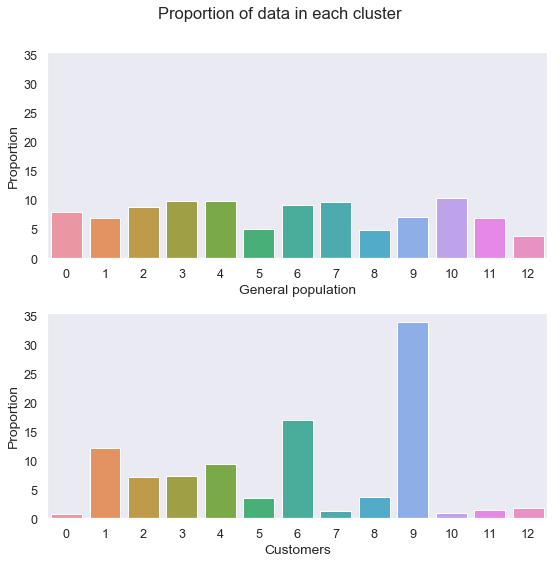

In [226]:
# Plot the proportion of data in each cluster 
# for the general population and the customers 
labels_distribution(labels, labels_customers)

Visually, the differences between the distributions are obvious. Additionally, the following table shows the proportion of data in each cluster, contrasting the customer data and the general population, side by side:

                    Customer | Population | Diff
        Cluster  0:     1%   |      8%    |  -7
        Cluster  1:    12%   |      7%    |  +5
        Cluster  2:     7%   |      9%    |  -2
        Cluster  3:     7%   |     10%    |  -3
        Cluster  4:     9%   |     10%    |  -1
        Cluster  5:     3%   |      5%    |  -2
        Cluster  6:    17%   |      9%    |  +8
        Cluster  7:     1%   |     10%    |  -9
        Cluster  8:     4%   |      5%    |  -1
        Cluster  9:    34%   |      7%    | +27
        Cluster 10:     1%   |     10%    |  -9
        Cluster 11:     1%   |      7%    |  -6
        Cluster 12:     2%   |      4%    |  -2
    

I found that the best way to evaluate the representativeness of population segments in the customer data was to contrast two clusters at a time: one that is overrepresented to one that is less represented in the customer data. 

For all comparisons below, I use Cluster \#9 as the benchmark, overrepresented cluster in the customers dataset. The proportion of people in Cluster \#9 is 27 percentage points higher in the customer base compared to the general population (34\% vs. 7\%).

Also, I change the names of the clusters to denote whether a given cluster is overrepresented or underrepresented, and by how much. For instance, Cluster \#9 above becomes Cluster +27, Cluster \#7 becomes Cluster -9(a), Cluster \#10 becomes Cluster -9(b), and so on. 

#### Cluster +26 vs. Cluster -9(b)

 To start I consider the most overrepresented segment — Cluster +26 — and contrast it with one of the two most underrepresented — Cluster -9(b). 

Cluster +26 and Cluster -9(b) are centered far from each other with respect to many important features in the original space: estimated age (and other directly associated features), gender, various dimensions of the financial and personality typologies, regional car ownership and housing type, and wealth. 

Specifically, the most overrepresented segment, Cluster +26, is centered on males in their late 40s and 50s; their financial typology is higher on dimensions like investing, and home ownership; their personality typology is substantially higher in dimensions like rational, critical, dominant, combative, religious, and traditional. They live in residential areas with high car ownership and high share of 1-2 family homes; they likely are upper-middle class and have older families.

The most underrepresented segment, Cluster -9(b), is centered on females in their 30s; their financial typology is high on dimensions like "low financial interest"; their personality typology is higher in dimensions like socially-minded and dreamful. They live in apartment buildings in average-to-poor urban regions with lower car ownership. They likely have low income and are lower-middle class; and are single or married without school-age children.

#### Cluster +26 vs. Cluster -9(a)

I then contrast Cluster +26 with the other most underrepresented segment: Cluster -9(a).

Cluster -9(a) seems to be centered on females, who are in a more similar socio-economic and geographic segment as the overrepresented Cluster +26. This groups looks analogous to Cluster -9(b) — analyzed above — with respect to gender and personality type; but in terms of economic measures and housing is actually more similar to Cluster +26.

In summary, Cluster -9(a) is approximately centered on females living in good suburban neighborhoods; they likely are middle-class, married, and have school age children.

#### Cluster +26 vs. Cluster -7

 Cluster -7 is centered on younger men, 30 - 45 years old, who are of similar socioeconomic status as the females in Cluster -9(b). They live in apartment buildings in average-to-poor urban regions. They likely are lower-middle class; and are single or married without school-age children.

 The demographics, other than gender, of these two clusters — Cluster -7 and Cluster -9(b) — are very similar; which leads me to believe that Cluster -7 captures the spouses or other males in the same social and community segment as the females in Cluster -9(b). 

#### Cluster +26 vs. Cluster +8

The other overrepresented segment is Cluster +8, and is centered closely to Cluster +26 (the most overrepresented segment) with respect to age, gender, financial typology, and personality typology. The males in Cluster +8 are less wealthy and live in smaller communities farther from urban centers.

My hypothesis is that Cluster +8 captures very similar individuals than Cluster +26, but instead of living in suburban, upper-middle class neighborhoods, the males in Cluster +8 live in more rural middle-class towns. 

### Conclusion: Target demographic of mail-order sales

The analysis above indicates that the clear target demographic for the mail-order sales consists of middle-aged men who show personality and social values that can be said to be traditional. They are more likely to be married with school-age children or have older families. These families likely own their dwellings in single- or dual-family buildings; which are located in upper-middle class suburban neighborhoods or in middle-class rural towns. 